##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License")

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# On Variational Bounds of Mutual Information
Ben Poole, Sherjil Ozair, A&auml;ron van den Oord, Alexander A. Alemi, George Tucker<br/>
*ICML 2019*<br/>
[paper](https://arxiv.org/abs/1905.06922) / [slides](https://docs.google.com/presentation/d/1dz0AVBy6VDz7SU43m0IQjuJDviEuf3NpWSeIWov_DYc/present?usp=sharing) / [video](https://www.facebook.com/icml.imls/videos/2202320806483370/?t=2562) / [poster](https://drive.google.com/file/d/1C5ZYqSJRaOupQelqYgVbc9lJ7__0CDXA/view?usp=sharing)

This notebook contains code for most of the variational bounds on mutual information presented in the paper, and experiments on the toy Gaussian problem. 

Comments? Complaints? Questions? Bug Ben on Twitter [@poolio](https://twitter.com/poolio)

<sup>Thanks to [Zhe Dong](https://www.linkedin.com/in/hoogendong/) for valuable feedback on this colab.</sup>

### Introduction

Here we give a brief overview of the challenges of MI estimation and a few of the variational bounds we presented in the paper. Please checkout the [paper](https://arxiv.org/abs/1905.06922) for more details.

Our goal is to build efficient estimators of mutual information (MI) that leverage neural networks. Mutual information is given by:
$$I(X; Y) = \mathbb{E}_{p(x,y)}\left[\log \frac{p(x,y)}{p(x)p(y)}\right].$$
Estimating MI is challenging as we often only have access to samples $x, y$ but do not know the densities.

To overcome these challenges, we review and presented several variational estimators of MI. These estimators replace the intractable MI objective with a tractable objective that lower or upper bounds MI, and depends on neural-network-powered critics and baselines. For example, the $I_\text{NWJ}$ bound is given by:

$$ I(X; Y) \ge 1 + \mathbb{E}_{p(x, y)} \left[\color{blue} f(x,y) \right] - \mathbb{E}_{p(x)p(y)} \left[  \exp{{\color{blue} f(x , y)}}\right] $$
where $\color{blue} f$ is a neural network that takes $x$ and $y$ as input and outputs a scalar.

Below, we code up several variational lower and upper bounds on mutual information:
- Existing lower bounds: $I_\text{NWJ}, \,I_\text{InfoNCE}$
- New lower bounds: $I_\text{TUBA},\, I_{\alpha},\, I_\text{JS}$
- Structured lower bound ($I_\text{TNCE}$) and upper bounds ($I_\text{BA}$, $I_\text{MBU}$) with known $p(y|x)$

Here's a table of the bounds we'll code up here as well as the mathematical objectives:
![Table of MI bounds](https://i.imgur.com/pvZtPLl.png)

We apply these bounds to a toy problem, where $(x, y)$ are jointly Gaussian, and we vary the correlation between $x$ and $y$ over time to increase the mutual information. For the bounds with neural network critics, we train the critics to tighten the variational bounds.

### Practical suggestions
- MI estimates with neural networks are highly sensitive to the representation of the input data, architecture, optimizer, and more. When applying these estimators to new datasets, you will need to experiment!
- For representation learning, the $I_\text{NCE}$ bounds are a good place to start. Implementing them is simple.
- For estimation, start with the $I_\alpha$ bounds with a small $\alpha$. The implementation is trickier, but they can greatly reduce variance vs. $I_\text{NWJ}$.
- If you have known structure use it. For example, if you know a conditional distribution $p(y|x)$, use one of the structured bounds. 

### Implementation notes:
- For most bounds, we will work with a matrix, denoted by `f` or `scores` that contains the output of the critic for every pair of elements in the minibatch: `scores[i, j] = critic(x[j], y[i])`
- Most variational lower bounds on MI require samples from both the joint $p(x, y)$ and marginal distributions $p(x)p(y)$. For a minibatch of size $K$, we have $K$ samples from the joint $p(x,y)$ and can form samples from the marginal by using all pairs $x_i, y_j$ where $i \ne j$, giving $K \times (K -1)$ samples from the marginal. The diagonal elements of the `scores` matrix correspond to the $K$ critic scores for samples from the joint, and the off-diagonal elements correspond to the critic scores for samples from the marginal.
- In this notebook we assume that we use all other elements in the minibatch as negative samples. For certain InfoMax tasks, for example when negatives come from the same image but at other spatial locations, one has to be more careful about summing over and selecting the right positive and negative examples to form the two expectations.
- Separable critics are the more efficient and popular architecture. Instead of having to do $K^2$ forward passes, you only have to do $2 \times K$ followed by an inner product. 

## Setup
Notebook should work in TF 1.X, but uses Eager-mode.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_probability as tfp
tfd = tfp.distributions
tfkl = tf.keras.layers
tfp = tfp.layers

import pandas as pd # used for exponential moving average
from scipy.special import logit
import numpy as np
import matplotlib.pyplot as plt

## Variational bound implementations
###  TUBA and NWJ lower bounds
The $I_\text{TUBA}$ variational lower bound on mutual information is given by:
$$ I(X; Y) \ge 1 + \mathbb{E}_{p(x, y)} \left[\log {e^{\color{blue} f(x,y)}\over{\color{green}  a(y)}} \right] - \mathbb{E}_{p(x)p(y)} \left[  \frac{e^{{\color{blue} f(x , y)}}}{\color{green} a(y)}\right] \triangleq I_\text{TUBA}$$
These bounds can be low bias, but are typically high variance. To implement this bound, we need the critic scores for all elements in the minibatch: `scores[i, j] = critic(x[i], y[j])`, and the value of the baseline `a[j] = baseline(y[j])` for every `y`. Instead of requiring the baseline to be non-negative, we assume that the argument passed in is $\log {\color{green} a(y)}$, and will exponentiate it to get the baseline ${\color{green} a(y)}$.

The implementation requires averaging the exponentiated critic over all independent samples, corresponding to the off-diagonal terms in `scores`,  which is done by the `reduce_logmeanexp_nodiag` function.

The $I_\text{NWJ}$ bound just uses the constant $e$ for the baseline, which is equivalent to adding 1 to the critic scores.

In [0]:
def reduce_logmeanexp_nodiag(x, axis=None):
  batch_size = x.shape[0].value
  logsumexp = tf.reduce_logsumexp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size)), axis=axis)
  if axis:
    num_elem = batch_size - 1.
  else:
    num_elem  = batch_size * (batch_size - 1.)
  return logsumexp - tf.math.log(num_elem)

def tuba_lower_bound(scores, log_baseline=None):
  if log_baseline is not None:
    scores -= log_baseline[:, None]
  batch_size = tf.cast(scores.shape[0], tf.float32)
  # First term is an expectation over samples from the joint,
  # which are the diagonal elmements of the scores matrix.
  joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
  # Second term is an expectation over samples from the marginal,
  # which are the off-diagonal elements of the scores matrix.
  marg_term = tf.exp(reduce_logmeanexp_nodiag(scores))
  return 1. + joint_term -  marg_term

def nwj_lower_bound(scores):
  # equivalent to: tuba_lower_bound(scores, log_baseline=1.)
  return tuba_lower_bound(scores - 1.) 

### InfoNCE contrastive lower bound
The InfoNCE variational lower bound is the easiest to implement, and typically provides low variance but high bias estimates of MI:
$$I(X; Y) \ge \mathbb{E}_{p^K(x,y)}\left[\frac{1}{K} \sum_{i=1}^K \log \frac{e^{\color{blue}f(x_i, y_i)}}{\frac{1}{K}\sum_{j=1}^K e^{\color{blue} f(x_j, y_i)}}\right].$$
The expectation $p^K(x,y)$ draws $K$ samples from the joint $(x, y)$. So for a minibatch of $K$ examples, we are effectively forming a single sample Monte-Carlo estimate of the quantity inside the expectation.

Here we use `reduce_logsumexp` so the implementation matches the math, but you can also implement this with `sparse_softmax_cross_entropy_with_logits` using a different label for each of the `K` elements in the minibatch.

In [0]:
def infonce_lower_bound(scores):
  """InfoNCE lower bound from van den Oord et al. (2018)."""
  nll = tf.reduce_mean(tf.linalg.diag_part(scores) - tf.reduce_logsumexp(scores, axis=1))
  # Alternative implementation:
  # nll = -tf.nn.sparse_softmax_cross_entropy_with_logits(logits=scores, labels=tf.range(batch_size))
  mi = tf.math.log(tf.cast(scores.shape[0].value, tf.float32)) + nll
  return mi

### Interpolated lower bounds
The interpolated lower bounds are the trickiest to implement, but also provide the best of both worlds: lower bias or variance relative to the NWJ and InfoNCE bounds. We start with the multisample TUBA bound from the paper:
$$I(X_1; Y) \geq 1+\mathbb{E}_{p(x_{1:K})p(y|x_1)}\left[\log \frac{e^{f(x_1,y)}}{a(y; x_{1:K})}\right]
- \mathbb{E}_{p(x_{1:K})p(y)}\left[ \frac{e^{f(x_1,y)}}{a(y; x_{1:K})}\right]$$
Coding up this bound is tricky as we need $K+1$ samples from the joint $p(x,y)$: $K$ of these samples are used for the first term, and the additional sample is used for the independent sample from $p(y)$ for the second term. In the minibatch setting, we can implement this by holding out the $j$th sample from the joint,  and using $y_j$ for the indepent sample from $p(y)$ for the second term, and $x_\ne j$ (all elements in the minibatch except element $j$) for the samples from $p(x_{1:K})$. A single-sample Monte-Carlo approximation to the NWJ bound is then given by:

$$1 + \log \frac{e^{f(x_1, y_1)}}{a(y_1; x_{\ne j}, \alpha)} - \frac{e^{f(x_1, y_j)}}{a(y_j; x_{\ne j}, \alpha)}$$
Instead of just using $(x_1, y_1)$ as the only positive example, we can use all samples from the joint in the minibatch: $(x_i, y_i)$. Summing over the $K$ elements which are not the element we are holding out for the second expectation ($y_j$), yields:
$$1 + \frac{1}{K}\sum_{i\ne j} \left(\log \frac{e^{f(x_i, y_i)}}{a(y_i; x_{\ne j}, \alpha)} - \frac{e^{f(x_i, y_j)}}{a(y_j; x_{\ne j}, \alpha)}\right)$$

Furthermore, in the minibatch setting we can choose any element in the minibatch to hold out for the second expectation. Summing over all possible (leave one out) combinations yields:
$$1 + \frac{1}{K+1} \sum_{j=1}^{K+1} \frac{1}{K}\sum_{i\ne j} \left(\log \frac{e^{f(x_i, y_i)}}{a(y_i; x_{\ne j}, \alpha)} - \frac{e^{f(x_i, y_j)}}{a(y_j; x_{\ne j}, \alpha)}\right)$$
where the interpolated baseline is given by $a(y; x_{1:M}) = \alpha \frac{1}{K} \sum_{l=1}^K e^{f(x_l, y)} + (1-\alpha) q(y)$. We work in log-space for numerical stability, using `compute_log_loomean` to compute the leave one out InfoNCE baselines, and `log_interpolate` to compute the log baseline for the interpolated bound.

In [0]:
def log_interpolate(log_a, log_b, alpha_logit):
  """Numerically stable implementation of log(alpha * a + (1-alpha) * b)."""
  log_alpha = -tf.nn.softplus(-alpha_logit)
  log_1_minus_alpha = -tf.nn.softplus(alpha_logit)
  y = tf.reduce_logsumexp(tf.stack((log_alpha + log_a, log_1_minus_alpha + log_b)), axis=0)
  return y

def compute_log_loomean(scores):
  """Compute the log leave-one-out mean of the exponentiated scores.

  For each column j we compute the log-sum-exp over the row holding out column j.
  This is a numerically stable version of:
  log_loosum = scores + tfd.softplus_inverse(tf.reduce_logsumexp(scores, axis=1, keepdims=True) - scores) 
  Implementation based on tfp.vi.csiszar_divergence.csiszar_vimco_helper.
  """
  max_scores = tf.reduce_max(scores, axis=1, keepdims=True)
  lse_minus_max = tf.reduce_logsumexp(scores - max_scores, axis=1, keepdims=True)
  d = lse_minus_max + (max_scores - scores)
  d_ok = tf.not_equal(d, 0.)
  safe_d = tf.where(d_ok, d, tf.ones_like(d))
  loo_lse = scores + tfd.softplus_inverse(safe_d)
  # Normalize to get the leave one out log mean exp
  loo_lme = loo_lse - tf.math.log(scores.shape[1].value - 1.)
  return loo_lme

def interpolated_lower_bound(scores, baseline, alpha_logit):
  """Interpolated lower bound on mutual information.

  Interpolates between the InfoNCE baseline ( alpha_logit -> -infty),
  and the single-sample TUBA baseline (alpha_logit -> infty)

  Args:
    scores: [batch_size, batch_size] critic scores
    baseline: [batch_size] log baseline scores
    alpha_logit: logit for the mixture probability

  Returns:
    scalar, lower bound on MI
  """
  batch_size = scores.shape[0].value
  # Compute InfoNCE baseline
  nce_baseline = compute_log_loomean(scores)
  # Inerpolated baseline interpolates the InfoNCE baseline with a learned baseline
  interpolated_baseline = log_interpolate(
      nce_baseline, tf.tile(baseline[:, None], (1, batch_size)), alpha_logit)
  # Marginal term.
  critic_marg = scores - tf.linalg.diag_part(interpolated_baseline)[:, None]
  marg_term = tf.exp(reduce_logmeanexp_nodiag(critic_marg))

  # Joint term.
  critic_joint = tf.linalg.diag_part(scores)[:, None] - interpolated_baseline
  joint_term = (tf.reduce_sum(critic_joint) -
                tf.reduce_sum(tf.linalg.diag_part(critic_joint))) / (batch_size * (batch_size - 1.))
  return 1 + joint_term  - marg_term

### JS-KL hybrid lower bound
We can also use different approaches for training the critic vs. estimating mutual informaiton. The $I_\text{JS}$ bound just trains the critic with the standard lower bound on the Jensen-Shannon divergence used in GANs, and then evaluates the critic using the $I_\text{NWJ}$ lower bound on KL (mutual information). 

We use a fun trick to simplify the code here:
`z = x + tf.stop_gradient(y - x)`.<br/>
`z` gives the value of `y` on the forward pass, but the gradient of `x` on the backward pass.

In [0]:
def js_fgan_lower_bound(f):
  """Lower bound on Jensen-Shannon divergence from Nowozin et al. (2016)."""
  f_diag = tf.linalg.tensor_diag_part(f)
  first_term = tf.reduce_mean(-tf.nn.softplus(-f_diag))
  n = tf.cast(f.shape[0], tf.float32)
  second_term = (tf.reduce_sum(tf.nn.softplus(f)) - tf.reduce_sum(tf.nn.softplus(f_diag))) / (n * (n - 1.))
  return first_term - second_term

def js_lower_bound(f):
  """NWJ lower bound on MI using critic trained with Jensen-Shannon.

  The returned Tensor gives MI estimates when evaluated, but its gradients are
  the gradients of the lower bound of the Jensen-Shannon divergence."""
  js = js_fgan_lower_bound(f)
  mi = nwj_lower_bound(f)
  return js + tf.stop_gradient(mi - js)

### Structured Bounds

See the end of the notebook for code for the structured bounds. The implementation when using these bounds is often different, as we use a known conditional distribution $p(y|x)$ instead of a critic function $f(x, y)$ that scores all pairs of points. For simplicity, we will just demonstrate the minibatch lower bound $I_\text{TNCE}$, which is equivalent to $I_\text{NCE}$ but using the critic $f(x,y) = \log p(y|x)$. 

### Putting it together

In [0]:
def estimate_mutual_information(estimator, x, y, critic_fn,
                                baseline_fn=None, alpha_logit=None):
  """Estimate variational lower bounds on mutual information.

  Args:
    estimator: string specifying estimator, one of:
      'nwj', 'infonce', 'tuba', 'js', 'interpolated'
    x: [batch_size, dim_x] Tensor
    y: [batch_size, dim_y] Tensor
    critic_fn: callable that takes x and y as input and outputs critic scores
      output shape is a [batch_size, batch_size] matrix
    baseline_fn (optional): callable that takes y as input 
      outputs a [batch_size]  or [batch_size, 1] vector
    alpha_logit (optional): logit(alpha) for interpolated bound

  Returns:
    scalar estimate of mutual information
  """
  scores = critic_fn(x, y)
  if baseline_fn is not None:
    # Some baselines' output is (batch_size, 1) which we remove here.
    log_baseline = tf.squeeze(baseline_fn(y))
  if estimator == 'infonce':
    mi = infonce_lower_bound(scores)
  elif estimator == 'nwj':
    mi = nwj_lower_bound(scores)
  elif estimator == 'tuba':
    mi = tuba_lower_bound(scores, log_baseline)
  elif estimator == 'js':
    mi = js_lower_bound(scores)
  elif estimator == 'interpolated':
    assert alpha_logit is not None, "Must specify alpha_logit for interpolated bound."
    mi = interpolated_lower_bound(scores, log_baseline, alpha_logit)
  return mi

## Neural network architectures

**Critics**: we consider two choices of neural network architectures for $\color{blue} f(x,y)$:
1. **Separable**: $f(x,y) = g(x)^Th(y)$ where $g$ and $h$ are two different MLPs
2. **Concat**: $f(x,y) = g([x, y])$ where we concatenate $x$ and $y$ and feed them into a single MLP

Using a separable baseline is typically more efficient, as you only have to do `batch_size` forward passes through each network vs. the `batch_size * batch_size` with the concat critic.

**Baselines**: we consider three possibilities for the baseline $\color{green}a(y)$:
1. **Constant**: $a(y)$ is a fixed constant (as in $I_\text{NWJ}$)
2. **Unnormalized**: $a(y)$ is a neural network that produces a scalar output (representing $\log a(y)$)
3. **Gaussian**: $a(y)$ is a Gaussian distribution. Here we fix the mean and variance to be 1, but you could use any tractable density with learnable parameters as well.

### Critics

In [0]:
def mlp(hidden_dim, output_dim, layers, activation):
  return tf.keras.Sequential(
      [tfkl.Dense(hidden_dim, activation) for _ in range(layers)] +
      [tfkl.Dense(output_dim)])
   

class SeparableCritic(tf.keras.Model):
  def __init__(self, hidden_dim, embed_dim, layers, activation, **extra_kwargs):
    super(SeparableCritic, self).__init__()
    self._g = mlp(hidden_dim, embed_dim, layers, activation)
    self._h = mlp(hidden_dim, embed_dim, layers, activation)

  def call(self, x, y):
    scores = tf.matmul(self._h(y), self._g(x), transpose_b=True)
    return scores


class ConcatCritic(tf.keras.Model):
  def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
    super(ConcatCritic, self).__init__()
    # output is scalar score
    self._f = mlp(hidden_dim, 1, layers, activation)

  def call(self, x, y):
    batch_size = tf.shape(x)[0]
    # Tile all possible combinations of x and y
    x_tiled = tf.tile(x[None, :],  (batch_size, 1, 1))
    y_tiled = tf.tile(y[:, None],  (1, batch_size, 1))
    # xy is [batch_size * batch_size, x_dim + y_dim]
    xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])
    # Compute scores for each x_i, y_j pair.
    scores = self._f(xy_pairs) 
    return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))


def gaussian_log_prob_pairs(dists, x):
  """Compute log probability for all pairs of distributions and samples."""
  mu, sigma = dists.mean(), dists.stddev()
  sigma2 = sigma**2
  normalizer_term = tf.reduce_sum(-0.5 * (np.log(2. * np.pi) + 2.0 *  tf.math.log(sigma)), axis=1)[None, :]
  x2_term = -tf.matmul(x**2, 1.0 / (2 * sigma2), transpose_b=True)
  mu2_term = - tf.reduce_sum(mu**2 / (2 * sigma2), axis=1)[None, :]
  cross_term = tf.matmul(x, mu / sigma2, transpose_b=True)
  log_prob = normalizer_term + x2_term + mu2_term + cross_term
  return log_prob

  
def build_log_prob_conditional(rho, **extra_kwargs):
  """True conditional distribution."""
  def log_prob_conditional(x, y):
    mu = x * rho
    q_y = tfd.MultivariateNormalDiag(mu, tf.ones_like(mu) * tf.cast(tf.sqrt(1.0 - rho**2), tf.float32))
    return gaussian_log_prob_pairs(q_y, y)
  return log_prob_conditional
  

CRITICS = {
    'separable': SeparableCritic,
    'concat': ConcatCritic,
    'conditional': build_log_prob_conditional,
}

### Baselines

In [0]:
def log_prob_gaussian(x):
  return tf.reduce_sum(tfd.Normal(0., 1.).log_prob(x), -1)

BASELINES= {
    'constant': lambda: None,
    'unnormalized': lambda: mlp(hidden_dim=512, output_dim=1, layers=2, activation='relu'),
    'gaussian': lambda: log_prob_gaussian,
}

## Experiments

### Dataset: correlated Gaussian
We experiment with a super simple correlated Gaussian dataset:
\begin{align}
x &\sim \mathcal{N}(0, I_d)\\
y &\sim \mathcal{N}(\rho x, (1 - \rho^2) I_d)
\end{align}
where $d$ is the dimensionality, and $\rho$ is the correlation. Each pair of dimensions $(x_i, y_i)$ has correlation $\rho$, and correlation 0 with all other dimensions. We can control the information by varying the correlation $\rho$:
$$I(X; Y) = -\frac{d}{2} \log \left(1 - \rho^2\right)$$

In [0]:
def sample_correlated_gaussian(rho=0.5, dim=20, batch_size=128):
  """Generate samples from a correlated Gaussian distribution."""
  x, eps = tf.split(tf.random.normal((batch_size, 2 * dim)), 2, axis=1)
  y = rho * x + tf.sqrt(tf.cast(1. - rho**2, tf.float32)) * eps
  return x, y

def rho_to_mi(dim, rho):
  return -0.5  * np.log(1-rho**2) * dim

def mi_to_rho(dim, mi):
  return np.sqrt(1-np.exp(-2.0 / dim * mi))

def mi_schedule(n_iter):
  """Generate schedule for increasing correlation over time."""
  mis = np.round(np.linspace(0.5, 5.5-1e-9, n_iter)) *2.0#0.1
  return mis.astype(np.float32)

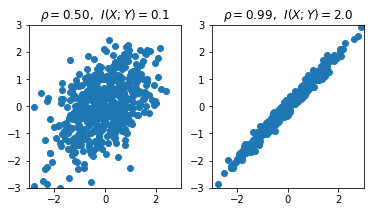

In [11]:
plt.figure(figsize=(6,3))
for i, rho in enumerate([0.5, 0.99]):
  plt.subplot(1, 2, i + 1)
  x, y = sample_correlated_gaussian(batch_size=500, dim=1, rho=rho)
  plt.scatter(x[:, 0], y[:, 0])
  plt.title(r'$\rho=%.2f$,  $I(X; Y)=%.1f$' % (rho, rho_to_mi(1, rho)))
  plt.xlim(-3, 3); plt.ylim(-3, 3);

### Training code

In [0]:
def train_estimator(critic_params, data_params, mi_params):
  """Main training loop that estimates time-varying MI."""
  # Ground truth rho is only used by conditional critic
  critic = CRITICS[mi_params.get('critic', 'concat')](rho=None, **critic_params)
  baseline = BASELINES[mi_params.get('baseline', 'constant')]()
  
  opt = tf.keras.optimizers.Adam(opt_params['learning_rate'])
  
  @tf.function
  def train_step(rho, data_params, mi_params):
    # Annoying special case:
    # For the true conditional, the critic depends on the true correlation rho,
    # so we rebuild the critic at each iteration.
    if mi_params['critic'] == 'conditional':
      critic_ = CRITICS['conditional'](rho=rho)
    else:
      critic_ = critic
    
    with tf.GradientTape() as tape:
      x, y = sample_correlated_gaussian(dim=data_params['dim'], rho=rho, batch_size=data_params['batch_size'])
      mi = estimate_mutual_information(mi_params['estimator'], x, y, critic_, baseline, mi_params.get('alpha_logit', None))
      loss = -mi
  
      trainable_vars = []
      if isinstance(critic, tf.keras.Model):
        trainable_vars += critic.trainable_variables 
      if isinstance(baseline, tf.keras.Model):
        trainable_vars += baseline.trainable_variables
      grads = tape.gradient(loss, trainable_vars)
      opt.apply_gradients(zip(grads, trainable_vars))
    return mi
  
  # Schedule of correlation over iterations 
  mis = mi_schedule(opt_params['iterations'])
  rhos = mi_to_rho(data_params['dim'], mis)
  
  estimates = []
  for i in range(opt_params['iterations']):
    estimates.append(train_step(rhos[i], data_params, mi_params).numpy())

  return np.array(estimates)

Dataset, optimization, and critic parameters. Try experimenting with these.

In [0]:
data_params = {
    'dim': 20,
    'batch_size': 64,
}

critic_params = {
    'layers': 2,
    'embed_dim': 32,
    'hidden_dim': 256,
    'activation': 'relu',
}

opt_params = {
    'iterations': 20000,
    'learning_rate': 5e-4,
}

Build a dictionary of the mutual information estimators to train and their parameters.

In [0]:
critic_type = 'concat' # or 'separable'

estimators = {
    'NWJ': dict(estimator='nwj', critic=critic_type, baseline='constant'),
    'TUBA': dict(estimator='tuba', critic=critic_type, baseline='unnormalized'),
    'InfoNCE': dict(estimator='infonce', critic=critic_type, baseline='constant'),
    'JS': dict(estimator='js', critic=critic_type, baseline='constant'),
    'TNCE': dict(estimator='infonce', critic='conditional', baseline='constant'),
    # Optimal critic for TUBA
    #'TUBA_opt': dict(estimator='tuba', critic='conditional', baseline='gaussian')
}

# Add interpolated bounds
def sigmoid(x):
  return 1/(1. + np.exp(-x))
for alpha_logit in [-5., 0., 5.]:
  name = 'alpha=%.2f' % sigmoid(alpha_logit)
  estimators[name] = dict(estimator='interpolated', critic=critic_type,
                          alpha_logit=alpha_logit, baseline='unnormalized')

Train each estimator and store mutual information estimates (this takes ~2 minutes on a modern GPU).

In [15]:
estimates = {}
for estimator, mi_params in estimators.items():
  print("Training %s..." % estimator)
  estimates[estimator] = train_estimator(critic_params, data_params, mi_params)

Training NWJ...
Training TUBA...
Training InfoNCE...
Training JS...
Training TNCE...
Training alpha=0.01...
Training alpha=0.50...
Training alpha=0.99...


### Results

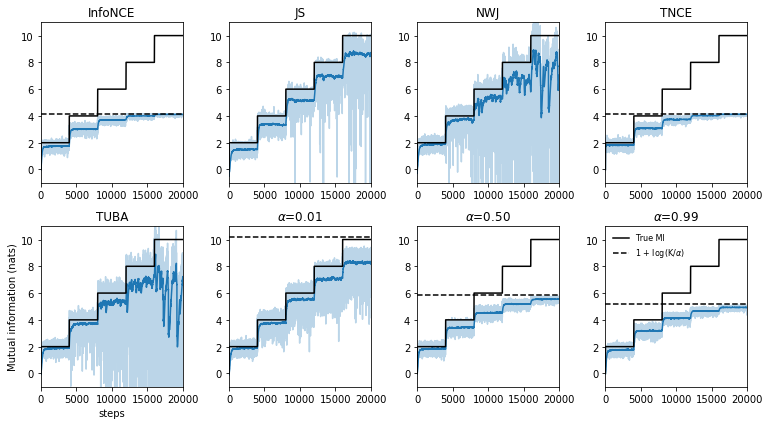

In [17]:
# Smooting span for Exponential Moving Average
EMA_SPAN = 200

# Ground truth MI
mi_true = mi_schedule(opt_params['iterations'])

# Names specifies the key and ordering for plotting estimators
names = np.sort(list(estimators.keys()))
lnames = list(map(lambda s: s.replace('alpha', '$\\alpha$'), names))

nrows = min(2, len(estimates))
ncols = int(np.ceil(len(estimates) / float(nrows)))
fig, axs = plt.subplots(nrows, ncols, figsize=(2.7 * ncols, 3 * nrows)) 
if len(estimates) == 1:
  axs = [axs]
axs = np.ravel(axs)
  
for i, name in enumerate(names):
  plt.sca(axs[i])
  plt.title(lnames[i])
  # Plot estimated MI and smoothed MI
  mis = estimates[name]  
  mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
  p1 = plt.plot(mis, alpha=0.3)[0]
  plt.plot(mis_smooth, c=p1.get_color())
  # Plot true MI and line for log(batch size)
  plt.plot(mi_true, color='k', label='True MI')
  estimator = estimators[name]['estimator']
  if 'interpolated' in estimator or 'nce' in estimator:
    # Add theoretical upper bound lines
    if 'interpolated' in estimator:
      log_alpha = -np.log( 1+ tf.exp(-estimators[name]['alpha_logit']))
    else:
      log_alpha = 1.
    plt.axhline(1 + np.log(data_params['batch_size']) - log_alpha, c='k', linestyle='--', label=r'1 + log(K/$\alpha$)' )
  plt.ylim(-1, mi_true.max()+1)
  plt.xlim(0, opt_params['iterations'])
  if i == len(estimates) - ncols:
    plt.xlabel('steps')
    plt.ylabel('Mutual information (nats)')
plt.legend(loc='best', fontsize=8, framealpha=0.0)
plt.gcf().tight_layout();

## Structured Bounds

The structured lower bounds use known conditional and learned marginal distributions to lower and upper bound mutual information. Check back soon for some more examples with these bounds!

In [0]:
def log_prob_pairs(dists, samples):
  if isinstance(dists, (tfd.Normal, tfd.MultivariateNormalDiag)):
    return gaussian_log_prob_pairs(dists, samples)
  batch_size = tf.shape(samples)[0]
  multiples = [1] * (1 + len(samples.get_shape().as_list()))
  multiples[1] = tf.shape(samples)[0]
  samples_tiled = tf.tile(samples[:, None], multiples)
  # Compute log probs, size [batch_size, batch_size]
  log_probs = dists.log_prob(samples_tiled)
  return log_probs

def variational_upper_bound(conditional_dist, marginal_dist, samples):
  """Variational upper bound on mutual information.

  Args:
    conditional_dist: true conditional density, p(y|x)
    marginal_dist: approximate marginal density, m(y)
    samples: samples from the conditional distribution p(y|x)

  Returns:
    scalar, upper bound on mutual information
  """
  return tf.reduce_mean(conditional_dist.log_prob(samples) -
                        marginal_dist.log_prob(samples))


def minibatch_upper_bound(conditional_dist, samples):
  """Minibatch upper bound on mutual information.

  Args:
    conditional_dist: approximate conditional density, e(y|x)
    samples: samples from conditional_dist

  Returns:
    scalar, upper bound on mutual information
  """
  log_probs = log_prob_pairs(conditional_dist, samples)
  # Batch marginal holds out self (along diagonal), and averages over
  # all other elements in the batch.
  mask = tf.eye(tf.shape(samples)[0])
  log_prob_marginal = tf.reduce_mean(reduce_logmeanexp_nodiag(log_probs, axis=1))
  log_prob_cond = tf.reduce_mean(tf.linalg.tensor_diag_part(log_probs))
  return log_prob_cond - log_prob_marginal

def minibatch_lower_bound(conditional_dist, samples):
  """Minibatch lower bound on mutual information.

  Args:
    conditional_dist: approximate conditional density, e(y|x)
    samples: samples from conditional_dist

  Returns:
    scalar, lower bound on mutual information
  """
  batch_marginal_dist = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(logits=tf.zeros(conditional_dist.batch_shape)),
      components_distribution=conditional_dist)
  return variational_upper_bound(conditional_dist, batch_marginal_dist, samples)